# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

In [1]:
%%info

In [2]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588622833464_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
jmespath                   0.9.4
lxml                       4.4.2
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pip                        20.1
py-dateutil                2.2
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

In [3]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package( "seaborn==0.10.0" )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
%matplotlib inline

In [6]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.2.0
lxml                       4.4.2
matplotlib                 3.2.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     1.0.3
pip                        20.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.4.1
seaborn                    0.10.0
setuptools                 46.1.3
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.34.2
windmill                   1.6

In [7]:
df=spark.read.json('s3://sta9760-data/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
type(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

## Overview of Data

Display the number of rows and columns in our dataset.

In [9]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [10]:
df.createOrReplaceTempView('business')
sqldf = spark.sql(
'''
SELECT business_id,name,city,state,categories
FROM business
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [11]:
df.select('categories').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|          categories|
+--------------------+
|Active Life, Gun/...|
|Health & Medical,...|
|Pets, Pet Service...|
|Hardware Stores, ...|
|Home Services, Pl...|
|Auto Repair, Auto...|
|Dry Cleaning & La...|
|Auto Repair, Oil ...|
|Ethnic Food, Food...|
|Martial Arts, Gym...|
+--------------------+
only showing top 10 rows

In [12]:
from pyspark.sql.functions import split, explode

category_1 = df.select(
"business_id",explode(split(df.categories, ', '))\
                                       .alias('category'))
category_1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|         Active Life|
|f9NumwFMBDn751xgF...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|            Shopping|
|Yzvjg0SayhoZgCljU...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Fitness & Instruc...|
|Yzvjg0SayhoZgCljU...|                Yoga|
|Yzvjg0SayhoZgCljU...|         Active Life|
|Yzvjg0SayhoZgCljU...|             Pilates|
|XNoUzKckATkOD1hP6...|                Pets|
|XNoUzKckATkOD1hP6...|        Pet Services|
|XNoUzKckATkOD1hP6...|        Pet Groomers|
|6OAZjbxqM5ol29BuH...|     Hardware Stores|
|6OAZjbxqM5ol29BuH...|       Home Services|
|6OAZjbxqM5ol29BuH...|   Building Supplies|
|6OAZjbxqM5ol29BuH...|       Home & Garden|
|6OAZjbxqM5ol29BuH...|            Shopping|
|51M2Kk903DFYI6gnB...|       Home Services|
|51M2Kk903DFYI6gnB...|            Plumbing|
|51M2Kk903DFYI6gnB...|        El

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [13]:
category_1.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [14]:
category_2 = df.select(explode(split(df.categories, ', '))\
                                       .alias('category'))\
.select('category').groupby('category').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Paddleboarding|   36|
|     Dermatologists|  341|
|   Historical Tours|   54|
|   Hot Air Balloons|   21|
|Mobile Home Dealers|   16|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [15]:
temp = category_1 .groupby('category')\
                    .count()\
                    .orderBy(['count'], ascending = False)
temp.show(20) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

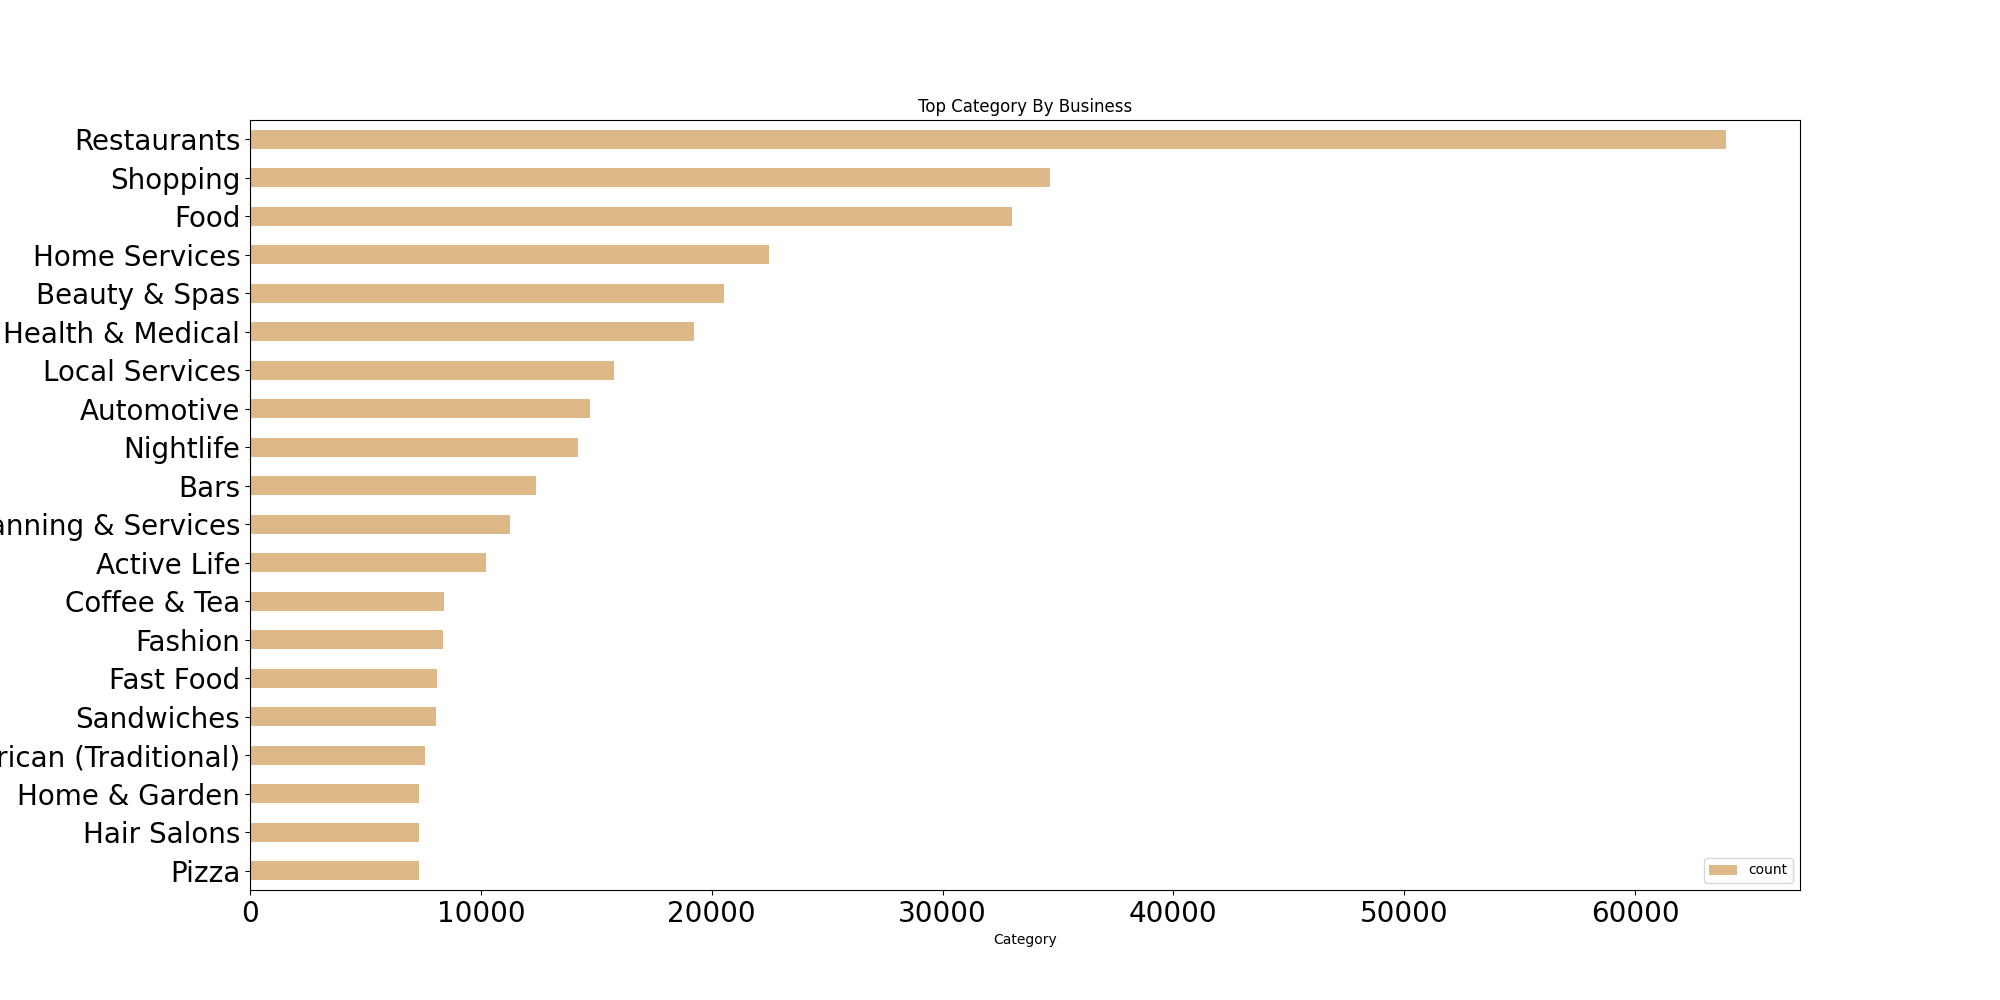

In [16]:
df_plt=temp.toPandas().sort_values(by='count',ascending=False).head(20).sort_values(by='count',ascending=True)\
.plot(x='category',y='count',kind='barh',fontsize=20,figsize=(20, 10), color = 'burlywood')
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Top Category By Business')
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [17]:
review=spark.read.json('s3://sta9760-data/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print(review.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None

In [19]:
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT business_id,stars
FROM review
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|HRxCNChQNu7maK29q...|  5.0|
|9WJd4cqm3ghYA2RxS...|  3.0|
|sAmmv3ffj99CN85Wj...|  5.0|
|oiAlXZPIFm2nBCt0D...|  1.0|
|EVkytEhlC1nswqmgr...|  4.0|
+--------------------+-----+

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [20]:
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT business_id,AVG(stars)
FROM review
GROUP BY business_id
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|PhrTUiNQVA_XsK43O...|              3.74|
|CwtjAViLdvXurW67H...| 4.083333333333333|
|CLxxUrk-Oop0q7Pim...|3.2857142857142856|
|2YUfXT7A-3rsDdWb_...| 2.574324324324324|
|J0f1QBIhXn9ahLuCs...| 3.272727272727273|
+--------------------+------------------+

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [21]:
df.createOrReplaceTempView('business')
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT DISTINCT AVG(review.stars) OVER (PARTITION BY review.business_id) AS review_stars,business.stars,name,city,state
FROM 
business
JOIN
review
ON business.business_id=review.business_id
ORDER BY review_stars DESC
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+--------------------+---------+-----+
|review_stars|stars|                name|     city|state|
+------------+-----+--------------------+---------+-----+
|         5.0|  5.0|Carolina Fitness ...|Fort Mill|   SC|
|         5.0|  5.0|Moores Taxes And ...|  Gilbert|   AZ|
|         5.0|  5.0|Dirty Do Mentions...|Henderson|   NV|
|         5.0|  5.0| Leno Fine Jewellery|  Calgary|   AB|
|         5.0|  5.0|Minute Muffler & ...|  Calgary|   AB|
+------------+-----+--------------------+---------+-----+

### 'Skew' Calculation
Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [22]:
sqldf = spark.sql(
'''
SELECT ROUND((review_stars-stars)/stars,3) as skew FROM
(SELECT DISTINCT AVG(review.stars) OVER (PARTITION BY review.business_id) AS review_stars,business.stars,name,city,state
FROM 
business
JOIN
review
ON business.business_id=review.business_id
)
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|  skew|
+------+
|   0.0|
|   0.0|
| -0.03|
| 0.048|
|-0.067|
| 0.036|
|-0.063|
|-0.023|
| 0.048|
|-0.033|
| -0.07|
|   0.0|
| 0.086|
|-0.024|
| -0.04|
|   0.0|
| 0.048|
| -0.02|
| 0.048|
|   0.0|
+------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

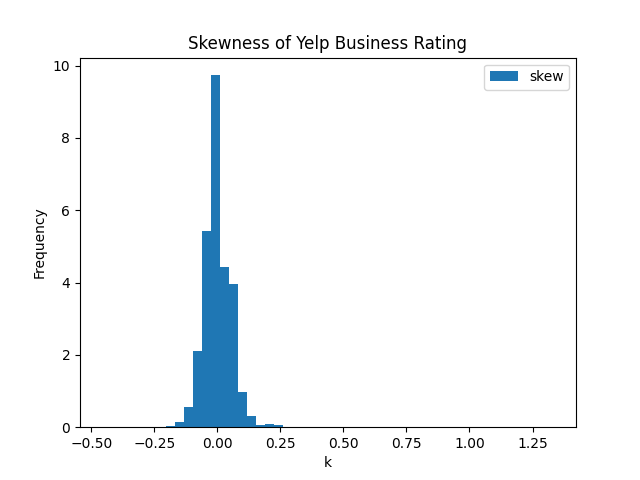

In [23]:
sqldf.toPandas().plot(kind='hist',bins=50,title = "Skewness of Yelp Business Rating",density=True)
plt.xlabel('k')
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

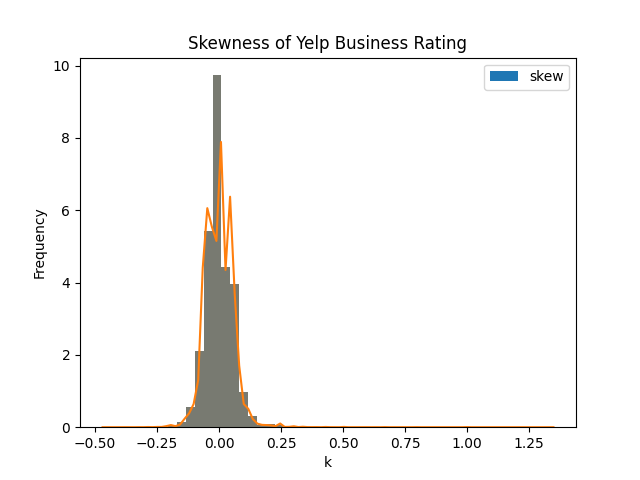

In [24]:
sns.distplot(sqldf.toPandas(), bins =50).\
    set(title = "Skewness of Yelp Business Rating")

%matplot plt

THe peak seems at a negative number. This hisgrams shows that reviewers who left a written response were more dissatisfied than normal.

# Will elite give higher stars review? 


## Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [25]:
user=spark.read.json('s3://sta9760-data/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print(user.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

None

In [62]:
user.createOrReplaceTempView('user')
user_top = spark.sql(
'''
SELECT user_id, elite, average_stars, review_count
FROM user
'''
)

user_top.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------+------------+
|             user_id|               elite|average_stars|review_count|
+--------------------+--------------------+-------------+------------+
|ntlvfPzc8eglqvk92...|                    |         3.57|         553|
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|         3.84|         564|
|zZUnPeh2hEp0WydbA...|                2010|         3.44|          60|
|QaELAmRcDc5TfJEyl...|                2009|         3.08|         206|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|         4.37|         485|
|z5_82komKV3mI4ASG...|                2007|         2.88|         186|
|ttumcu6hWshk_EJVW...|                    |          4.0|          12|
|f4_MRNHvN-yRn7EA8...|2011,2012,2013,20...|         3.63|         822|
|UYACF30806j2mfbB5...|                    |         3.75|          14|
|QG13XBbgHWydzThRB...|           2008,2009|          4.1|         218|
|f6YuZP6iennHFVlnF...|                    |          3.8|           5|
|I_6wY

In [26]:
print(review.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None

In [63]:
review.createOrReplaceTempView('review')
review_top = spark.sql(
'''
SELECT user_id, business_id, stars
FROM review
'''
)

review_top.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----+
|             user_id|         business_id|stars|
+--------------------+--------------------+-----+
|OwjRMXRC0KyPrIlcj...|-MhfebM0QIsKt87iD...|  2.0|
|nIJD_7ZXHq-FX8byP...|lbrU8StCq3yDfr-QM...|  1.0|
|V34qejxNsCbcgD8C0...|HQl28KMwrEKHqhFrr...|  5.0|
|ofKDkJKXSKZXu5xJN...|5JxlZaqCnk1MnbgRi...|  1.0|
|UgMW8bLE0QMJDCkQ1...|IS4cv902ykd8wj1TR...|  4.0|
|5vD2kmE25YBrbayKh...|nlxHRv1zXGT0c0K51...|  5.0|
|aq_ZxGHiri48TUXJl...|Pthe4qk5xh4n-ef-9...|  5.0|
|dsd-KNYKMpx6ma_sR...|FNCJpSn0tL9iqoY3J...|  5.0|
|P6apihD4ASf1vpPxH...|e_BiI4ej1CW1F0EyV...|  5.0|
|jOERvhmK6_lo_XGUB...|Ws8V970-mQt2X9CwC...|  4.0|
|s5j_CRBWDCCMDJ6r7...|PA61Rwk3AMwOEXHev...|  5.0|
|HJECayULRM-6xh2GC...|l-nL4BmhzpZjcavoo...|  4.0|
|1YIQGP-a534nyksaw...|Naa6E0YU0Wr7jCuCE...|  5.0|
|qftVgPj_kRTildMDj...|Ns4tjgLfqR1qawGlN...|  5.0|
|5lb0POg2t-AkMFx66...|ZlCSsWS07JulSBIQl...|  5.0|
|TF4C-F5iqavACQgKT...|7Ka9Pd8X9SRHs1D5E...|  1.0|
|2hRe26HSCAWbFRn5W...|d4qwVw4PcN-_2mK2o...|  1.0|


### The Total Elite Users On Yelp

In [45]:
elite_user = spark.sql(
'''
SELECT user_id, average_stars, review_count, (CASE
WHEN elite like '' THEN 'NO' ELSE 'YES' END)AS Elite_Squad
FROM user
'''
)

elite_user.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+------------+-----------+
|             user_id|average_stars|review_count|Elite_Squad|
+--------------------+-------------+------------+-----------+
|7fOIDwj7xovQ6igNg...|          4.4|           5|         NO|
|z8V2oPYZLUTLXB0UU...|         4.53|          51|         NO|
|Rj14umKuoJwBE2GS1...|         4.03|         210|        YES|
|TD4cJafak4HMZNLnQ...|         4.18|          32|         NO|
|m_7E3dV1W79Cj7WvM...|         3.84|         109|        YES|
+--------------------+-------------+------------+-----------+

In [32]:
user.createOrReplaceTempView('user')
elite_df = spark.sql(
'''
SELECT (CASE WHEN elite like '' THEN 'NO' ELSE 'YES' END)AS Elite,
COUNT((CASE WHEN elite like '' THEN 'NO' ELSE 'YES' END)) AS Count 
FROM user
GROUP BY (CASE WHEN elite like '' THEN 'NO' ELSE 'YES' END)

'''
)

elite_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+
|Elite|  Count|
+-----+-------+
|  YES|  75961|
|   NO|1892742|
+-----+-------+

### Elite Users Per Year

In [37]:
sqldf = spark.sql(
'''
SELECT
SUM((CASE WHEN elite LIKE '%2007%' THEN 1 ELSE 0 END)) as Elite_07,
SUM((CASE WHEN elite LIKE '%2008%' THEN 1 ELSE 0 END)) as Elite_08,
SUM((CASE WHEN elite LIKE '%2009%' THEN 1 ELSE 0 END)) as Elite_09,
SUM((CASE WHEN elite LIKE '%2010%' THEN 1 ELSE 0 END)) as Elite_10,
SUM((CASE WHEN elite LIKE '%2011%' THEN 1 ELSE 0 END)) as Elite_11,
SUM((CASE WHEN elite LIKE '%2012%' THEN 1 ELSE 0 END)) as Elite_12,
SUM((CASE WHEN elite LIKE '%2013%' THEN 1 ELSE 0 END)) as Elite_13,
SUM((CASE WHEN elite LIKE '%2014%' THEN 1 ELSE 0 END)) as Elite_14,
SUM((CASE WHEN elite like '%2015%' THEN 1 ELSE 0 END)) AS elite_15,
SUM((CASE WHEN elite like '%2016%' THEN 1 ELSE 0 END)) AS elite_16,
SUM((CASE WHEN elite like '%2017%' THEN 1 ELSE 0 END)) AS elite_17,
SUM((CASE WHEN elite like '%2018%' THEN 1 ELSE 0 END)) AS elite_18

FROM user
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|Elite_07|Elite_08|Elite_09|Elite_10|Elite_11|Elite_12|Elite_13|Elite_14|elite_15|elite_16|elite_17|elite_18|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    2368|    3592|    6369|   10238|   12809|   17362|   18223|   20508|   26409|   32128|   38645|   43026|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

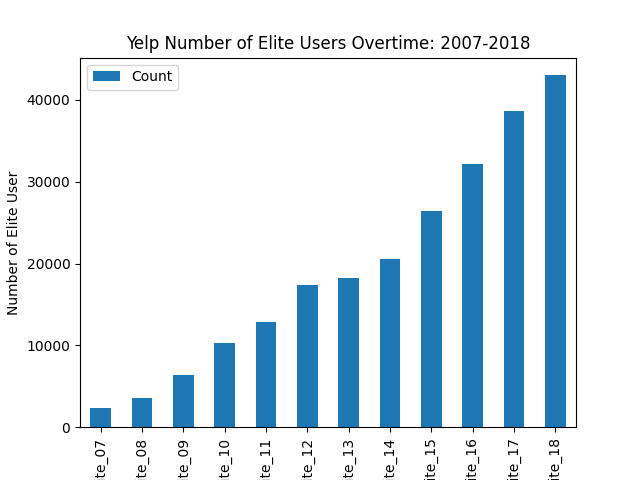

In [38]:
Number_of_Elite=sqldf.toPandas().transpose()
Number_of_Elite.columns = ['Count'] 
Number_of_Elite.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Elite User')
plt.title('Yelp Number of Elite Users Overtime: 2007-2018')
%matplot plt

In [61]:
elite_user.createOrReplaceTempView('elite_user')
review_star_diff = spark.sql(
'''
SELECT business_id, review.user_id, abs(stars-average_stars) AS diff, Elite_Squad
FROM elite_user
JOIN review
ON review.user_id = elite_user.user_id
'''
)

review_star_diff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------------+-----------+
|         business_id|             user_id|               diff|Elite_Squad|
+--------------------+--------------------+-------------------+-----------+
|Eng53R4ZvchGfwtxj...|7fOIDwj7xovQ6igNg...| 2.4000000000000004|         NO|
|cKRMmytHxaSt8F0SM...|TD4cJafak4HMZNLnQ...| 0.8200000000000003|         NO|
|qFAw6wHMMcr4ctF-Z...|m_7E3dV1W79Cj7WvM...|0.16000000000000014|        YES|
|3nf-a84p8LC41_WAI...|Rj14umKuoJwBE2GS1...| 0.9699999999999998|        YES|
|XTtNTWH_Nqv27RC7O...|Rj14umKuoJwBE2GS1...| 1.0300000000000002|        YES|
|YvVEZIfkxRktT07IB...|z8V2oPYZLUTLXB0UU...|0.46999999999999975|         NO|
|zwNLJ2VglfEvGu7DD...|Rj14umKuoJwBE2GS1...| 1.0300000000000002|        YES|
|OdViVhR2ayppzkN2W...|Rj14umKuoJwBE2GS1...|0.03000000000000025|        YES|
|Gyrez6K8f1AyR7dzW...|Rj14umKuoJwBE2GS1...| 2.0300000000000002|        YES|
|mzBNBDhlTmhBjDJ1-...|Rj14umKuoJwBE2GS1...|0.03000000000000025|        YES|
|IT_4EEIbv6O

In [64]:
review_star_diff.createOrReplaceTempView('review_star_diff')
Elite = spark.sql(
'''
SELECT diff
FROM review_star_diff
WHERE Elite_Squad = 'YES'
'''
)

Elite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|               diff|
+-------------------+
|               0.56|
| 0.6299999999999999|
| 0.8399999999999999|
| 1.1600000000000001|
| 0.9199999999999999|
| 1.8399999999999999|
| 0.8399999999999999|
|0.16000000000000014|
| 1.1600000000000001|
| 0.9199999999999999|
|0.16000000000000014|
|               0.56|
|               0.56|
| 0.8399999999999999|
| 0.8399999999999999|
|0.16000000000000014|
|0.16000000000000014|
| 1.1600000000000001|
|0.16000000000000014|
|0.16000000000000014|
+-------------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

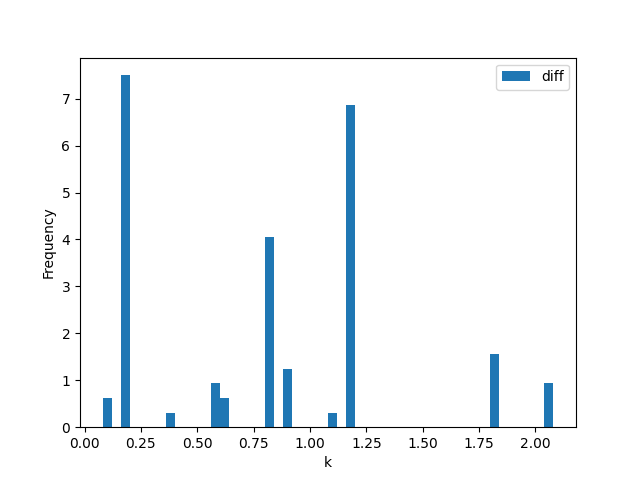

In [68]:
Elite.toPandas().plot(kind='hist',bins=50,density=True)
plt.xlabel('k')
%matplot plt

In [65]:
review_star_diff.createOrReplaceTempView('review_star_diff')
NOT_Elite = spark.sql(
'''
SELECT diff
FROM review_star_diff
WHERE Elite_Squad = 'NO'
'''
)

NOT_Elite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                diff|
+--------------------+
|  0.9500000000000002|
|  0.8300000000000001|
| 0.11000000000000032|
|  0.8899999999999997|
| 0.11000000000000032|
|  0.8899999999999997|
|                 0.0|
|0.040000000000000036|
|0.040000000000000036|
| 0.11000000000000032|
|  0.8899999999999997|
|                1.17|
|                 3.0|
| 0.11000000000000032|
| 0.16999999999999993|
|  3.1100000000000003|
|  0.8899999999999997|
|  3.1100000000000003|
|  0.8300000000000001|
|  0.8899999999999997|
+--------------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

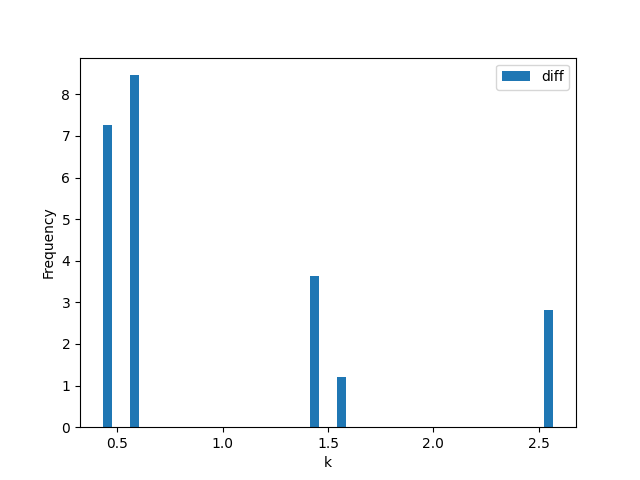

In [69]:
NOT_Elite.toPandas().plot(kind='hist',bins=50,density=True)
plt.xlabel('k')
%matplot plt